In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
import geo
import os
import avwx.tds
from mpl_toolkits.basemap import Basemap
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style"))

In [214]:
def divide_chunks(l, n): 
    return [l[i:i+n] for i in range(0, len(l), n)]
        
def get_metars(stations, batch_size=500, cache=None):
    if cache is not None and os.path.exists(cache):
        return pd.read_pickle(cache)
    
    metars = {}
    for batch in divide_chunks(stations, 500):
        data = avwx.tds.get_latest_metar(batch)
        metars.update(data)
        # get all the metars
    metar_table = pd.DataFrame(metars.values())
    metar_table = metar_table.drop(columns=['raw_xml'])
    front_cols = ['station_id', 'observation_time']
    metar_table = metar_table.reindex(columns=front_cols + [c for c in metar_table.columns.tolist() if c not in front_cols])
    if cache is not None:
        metar_table.to_pickle(cache)
    return metar_table

In [4]:
def load_towers():
    import struct
    s = struct.Struct("4x 4s 1s 1s 1s 1s 300s 1296x")
    with open('data/NASR/TWR.txt', 'rb') as f:
        towers = pd.DataFrame([[y.decode().strip() for y in s.unpack_from(x)] for x in f if x.startswith(b"TWR8")])
        towers.columns = ['faa_id', 'bravo', 'charlie', 'delta', 'echo', 'hours']
        towers = towers.sort_values(by='faa_id')
        for cls in ['bravo', 'charlie', 'delta', 'echo']:
            towers[cls] = towers[cls] == 'Y'
    return towers

In [5]:
def dms_to_dec(dms):
    """
    Convert degrees-minutes-seconds to decimal.
    dms_to_dec("41-04-01.0299N") -> 41.066952750000006
    dms_to_dec("073-42-27.2396W")-> -73.70756655555556
    """
    direction = dms[-1]
    deg, minutes, seconds = map(float, dms[:len(dms)-1].split("-"))
    dec = deg + minutes/60 + seconds/3600
    if direction in ('W', 'S'):
        dec = dec * -1
    return dec

# Collect Data

In [6]:
towers = load_towers()
conn = sqlite3.connect("data/nasr.db")
airports = pd.read_sql_query("SELECT apt.icao_id as station_id, apt.faa_id as faa_id, apt.latitude_dms, apt.longitude_dms, apt.name, apt.city, apt.state_code, apt.state_name, CAST(AVG(rwy.length) as INT) as mean, COUNT(*) as count, MAX(rwy.length) as max, MIN(rwy.length) as min FROM runways rwy LEFT JOIN airports apt ON rwy.facility_site_number = apt.facility_site_number wHERE apt.facility_type='AIRPORT' AND apt.facility_use='PU' AND rwy.name not like 'H%' AND apt.icao_id IS NOT NULL GROUP BY apt.icao_id  ORDER BY MEAN", conn)

# convert airports latitude and longitude into decimals
for degc, dmsc in [('latitude', 'latitude_dms'), ('longitude', 'longitude_dms')]:
    airports[degc] = airports[dmsc].apply(dms_to_dec)

In [7]:
metars = get_metars(airports['station_id'], cache='data/metars.pkl')
# Remove coordinates from metar data, will use FAA data instead
metars = metars[[x for x in metars.columns if x not in ('latitude', 'longitude')]]

# Exclude Airports

In [8]:
include_airports = ['MYNN', 'MYGF']
# Exclude Guam
exclude_airports = ['TNI', 'GUM']
# Exclude Puerto Rico
exclude_airports.extend(['SIG', 'SJU', 'BQN', 'CPX', 'ABO', 'VQS', 'MAZ', 'PSE', 'RVR'])
# Exclude Micronesia, Mariana Islands
exclude_airports.extend(['TTK', 'T11', 'TKK', 'PNI', 'GRO', 'ROR', 'GSN', 'MAJ', ])
# Exclude American Somoa
exclude_airports.extend(['Z08', 'FAQ', 'PPG'])
# Exclude Virgin Islands
exclude_airports.extend(['STT', 'STX', 'TUPJ'])
# Exclude Aruba, Saint Martin, Anguilla
exclude_airports.extend(['TNCE', 'TNCM', 'TFFG', 'TQPF'])
# Exclude Canada, Bermuda 
exclude_airports.extend(['CYSU', 'CYSJ', 'CYSL', 'TXKF'])
# Exclude airports without a state code
exclude_airports.extend(airports[airports['state_code'].isna()]['faa_id'])
# Exclude Hawaii, Alaska, and Midway
exclude_airports.extend(airports[airports['state_code'].isin(['HI', 'AK','MQ'])]['faa_id'])
airports['excluded'] = airports['faa_id'].isin(exclude_airports)
airports['excluded'] = airports['excluded'] & ~airports['faa_id'].isin(include_airports)
# Remove excluded airports
airports = airports[~airports['excluded']]

In [9]:
len(airports)

2129

# Merge Data

In [10]:
data = pd.merge(airports, metars, on='station_id', how='left')
data = pd.merge(data, towers, on='faa_id', how='left')
data = data.fillna(value={'bravo': False, 'charlie': False, 'delta': False, 'echo': False})
data['elevation_ft'] = data['elevation_m'] * 3.281
data['airspace'] = data.apply(lambda x: 'B' if x['bravo'] else 'C' if x['charlie'] else 'D' if x['delta'] else 'E' if x['echo'] else 'G', axis=1)
data = data.set_index(data['station_id'])
state_long = data.groupby('state_code')[['longitude', 'latitude']].min().rename(columns={'longitude': 'min_longitude', 'latitude': 'min_latitude'})
data = data.join(state_long, on='state_code', how='left')

In [11]:
nometars = data[data['observation_time'].isna()]
# Exclude data without metar information
data = data[~data['observation_time'].isna()]

In [213]:
data.to_pickle('data/data.pkl')
metars.to_pickle('data/metars.pkl')

# Runway Length Distribution

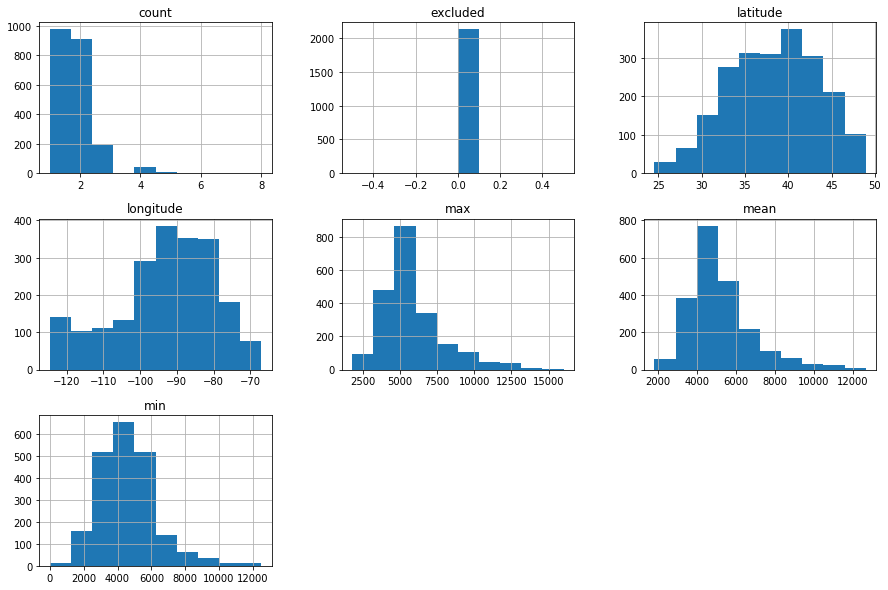

In [12]:
airports.hist(figsize=(15, 10));

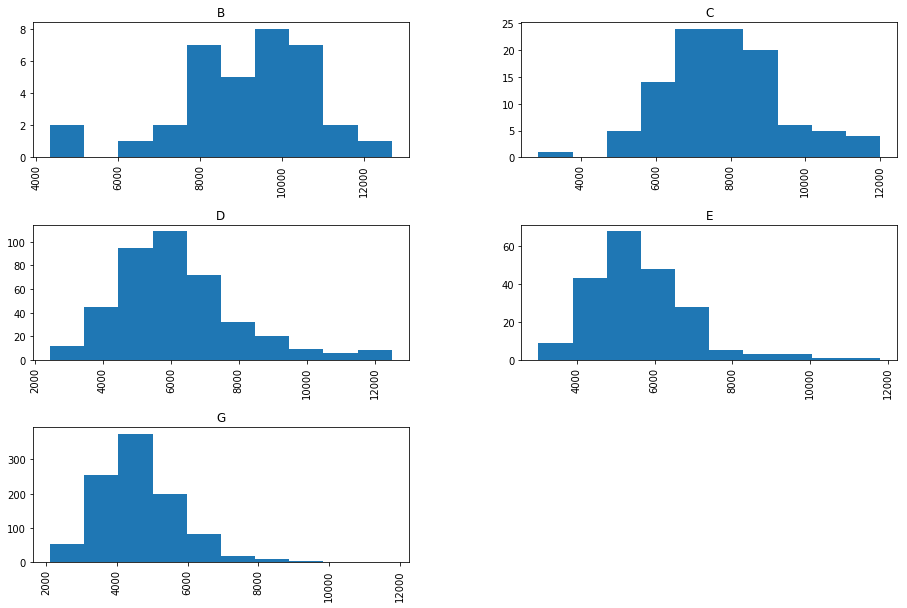

In [13]:
data['mean'].hist(by=data['airspace'], figsize=(15,10));

# Various Charts

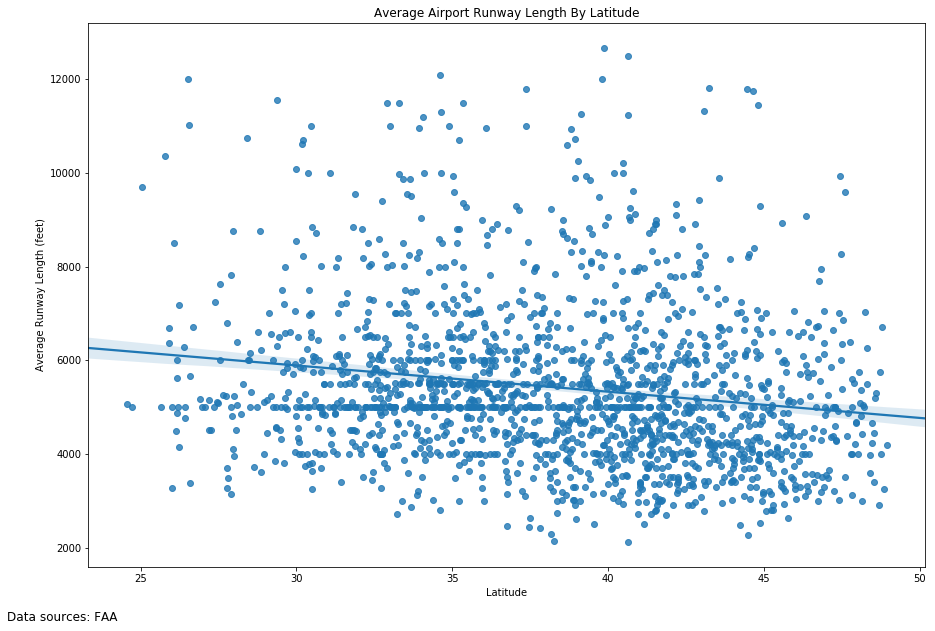

In [14]:
plt.figure(figsize=(15, 10))
axes = sns.regplot(x='latitude', y='mean', data=data)
axes.set_title("Average Airport Runway Length By Latitude")
axes.set_xlabel("Latitude")
axes.set_ylabel("Average Runway Length (feet)")
axes.get_figure().text(0.05, 0.05, "Data sources: FAA", fontsize=12);

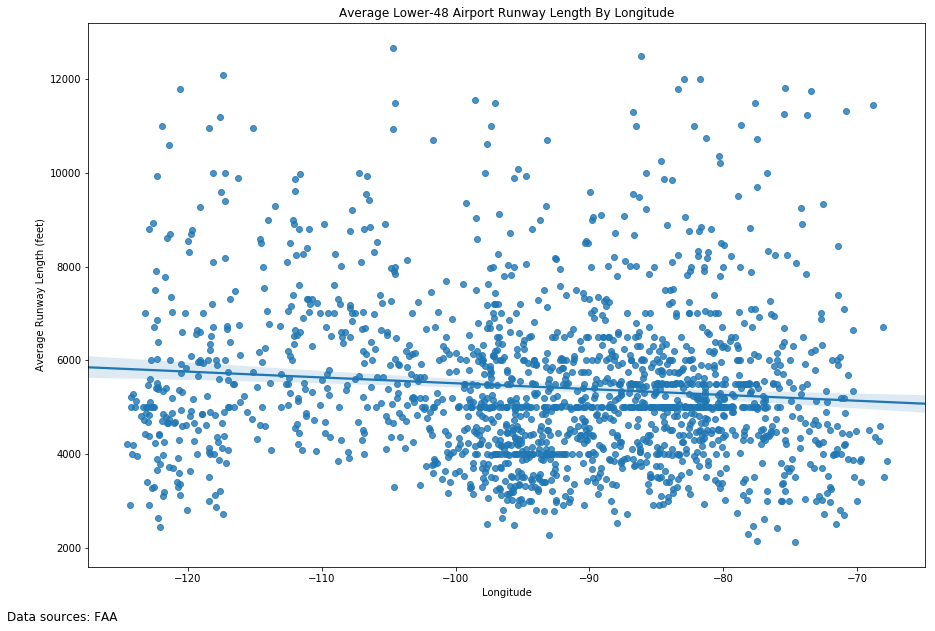

In [15]:
#data.plot.scatter(x='longitude', y='mean', figsize=(15, 10));
plt.figure(figsize=(15, 10))
axes = sns.regplot(x='longitude', y='mean', data=data[(data['longitude'] >= -125) &
                                                      (data['longitude'] <= -65)]);
axes.set_title("Average Lower-48 Airport Runway Length By Longitude")
axes.set_xlabel("Longitude")
axes.set_ylabel("Average Runway Length (feet)")
axes.get_figure().text(0.05, 0.05, "Data sources: FAA", fontsize=12);

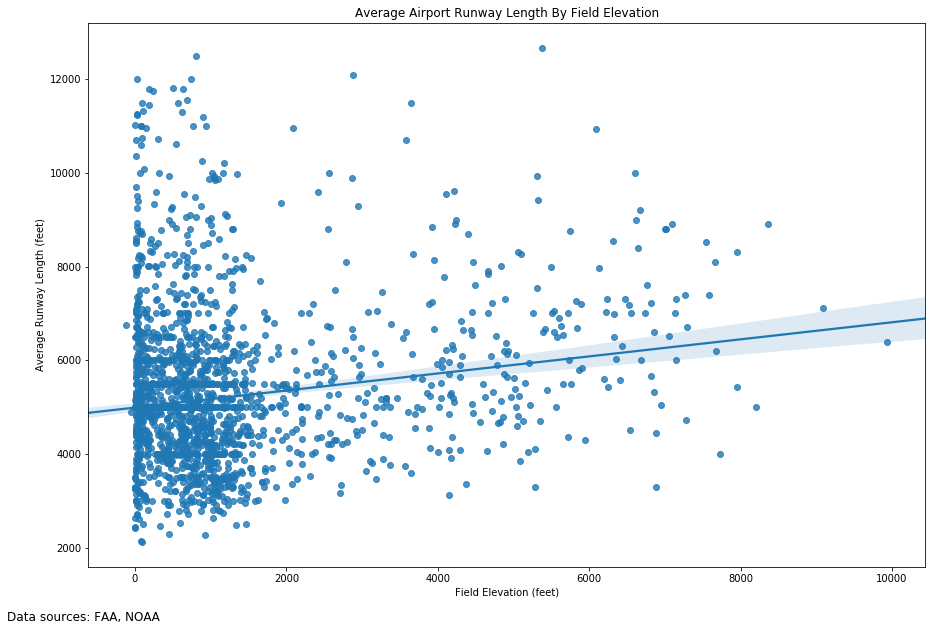

In [35]:
plt.figure(figsize=(15, 10))
axes = sns.regplot(x='elevation_ft', y='mean', data=data, robust=True)
axes.set_title("Average Airport Runway Length By Field Elevation")
axes.set_xlabel("Field Elevation (feet)")
axes.set_ylabel("Average Runway Length (feet)")
axes.get_figure().text(0.05, 0.05, "Data sources: FAA, NOAA", fontsize=12);

# Maps

In [17]:
def airport_map_plot(data, title="United States (Lower 48) Public Use Airports", hue='airspace', palette=None):
    plt.figure(figsize=(25, 18))
    axes = sns.scatterplot(x='longitude', y='latitude', data=data, hue=hue, palette=palette)
    axes.set_title(title, fontsize=20)
    axes.set_xlabel("Longitude")
    axes.set_ylabel("Latitude")
    axes.get_figure().text(0.05, 0.05, "Data sources: FAA", fontsize=12);
    return axes

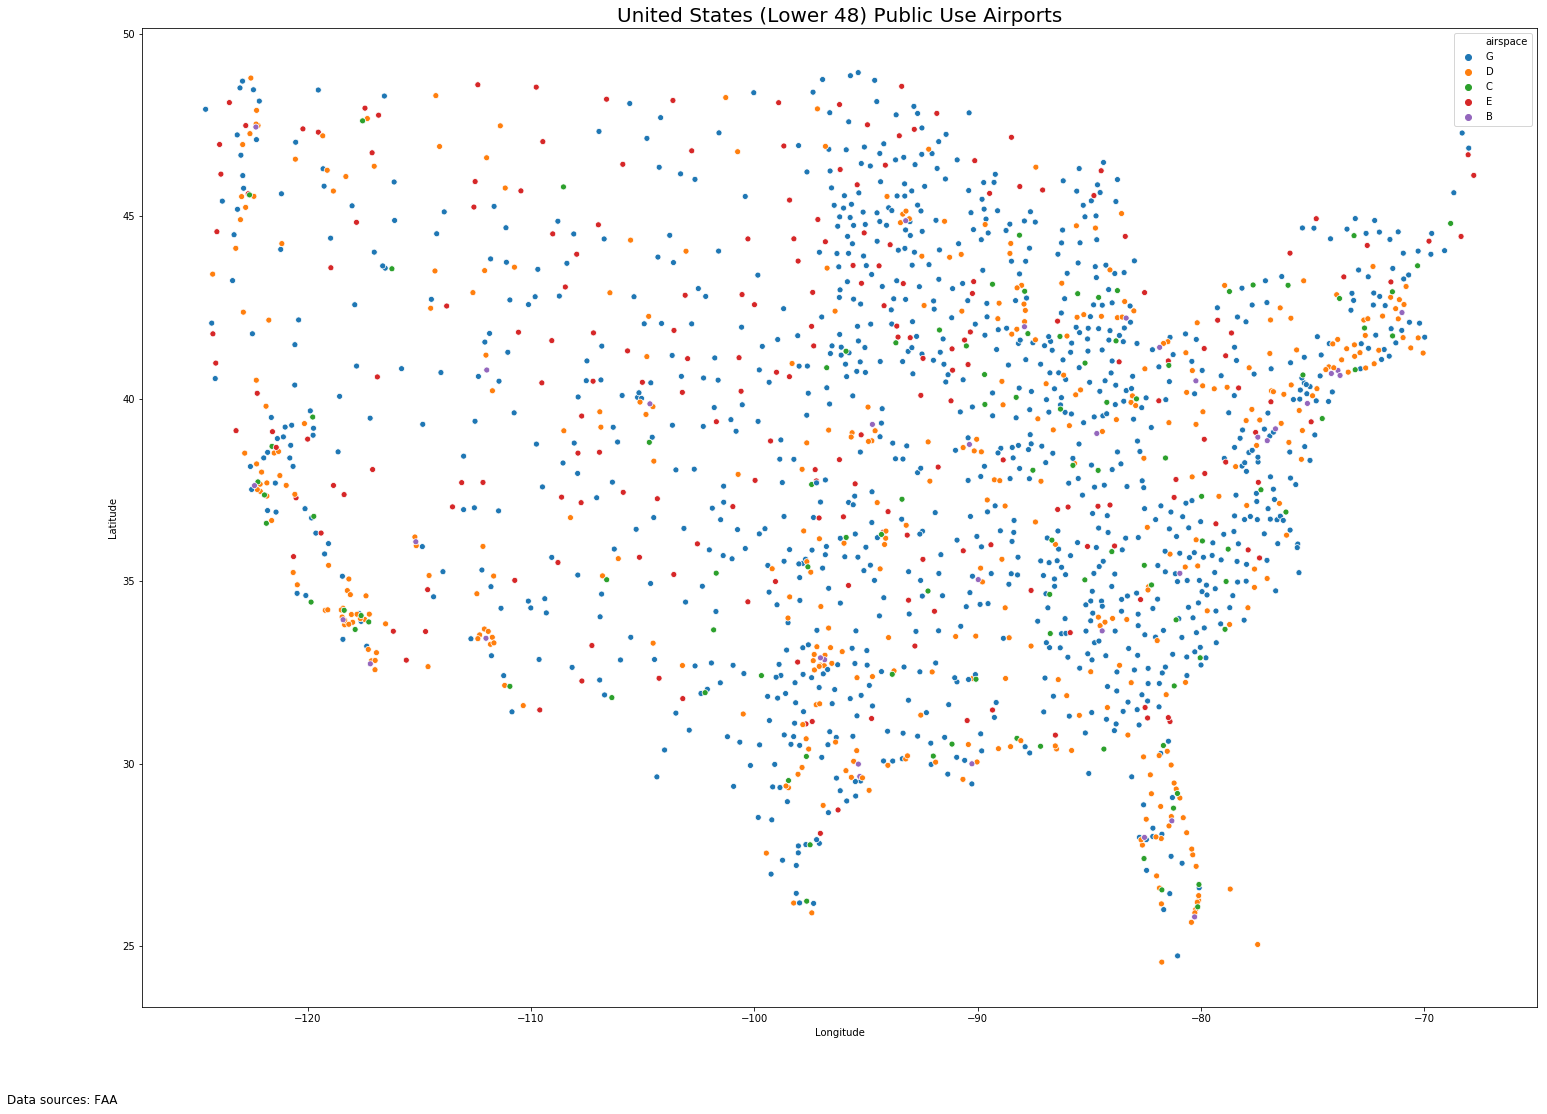

In [18]:
airport_map_plot(data);

# Picking a Subset of Airports

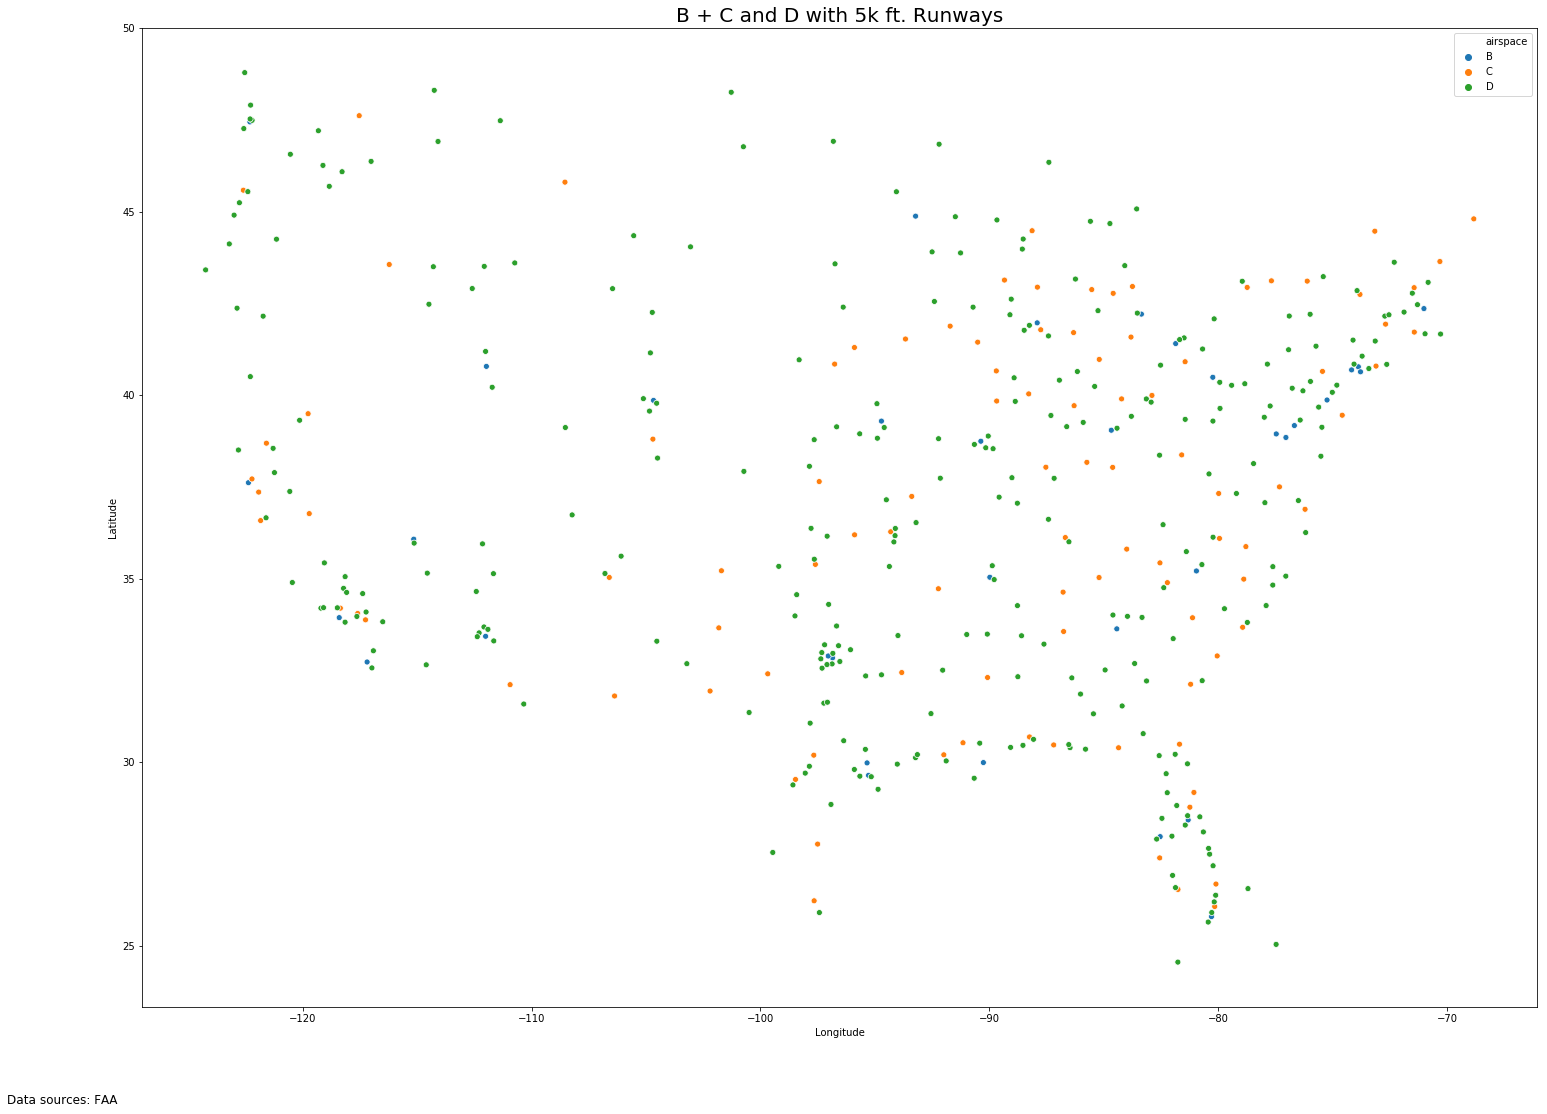

In [19]:
class_b = data[data['airspace'] == 'B']
class_c_long = data[(data['airspace'] == 'C') & (data['mean'] >= 5000)]
class_d_long = data[(data['airspace'] == 'D') & (data['mean'] >= 5000)]
data_subset = pd.concat([class_b, class_c_long, class_d_long])
airport_map_plot(data_subset, title="B + C and D with 5k ft. Runways");

# Chosen Airports by State

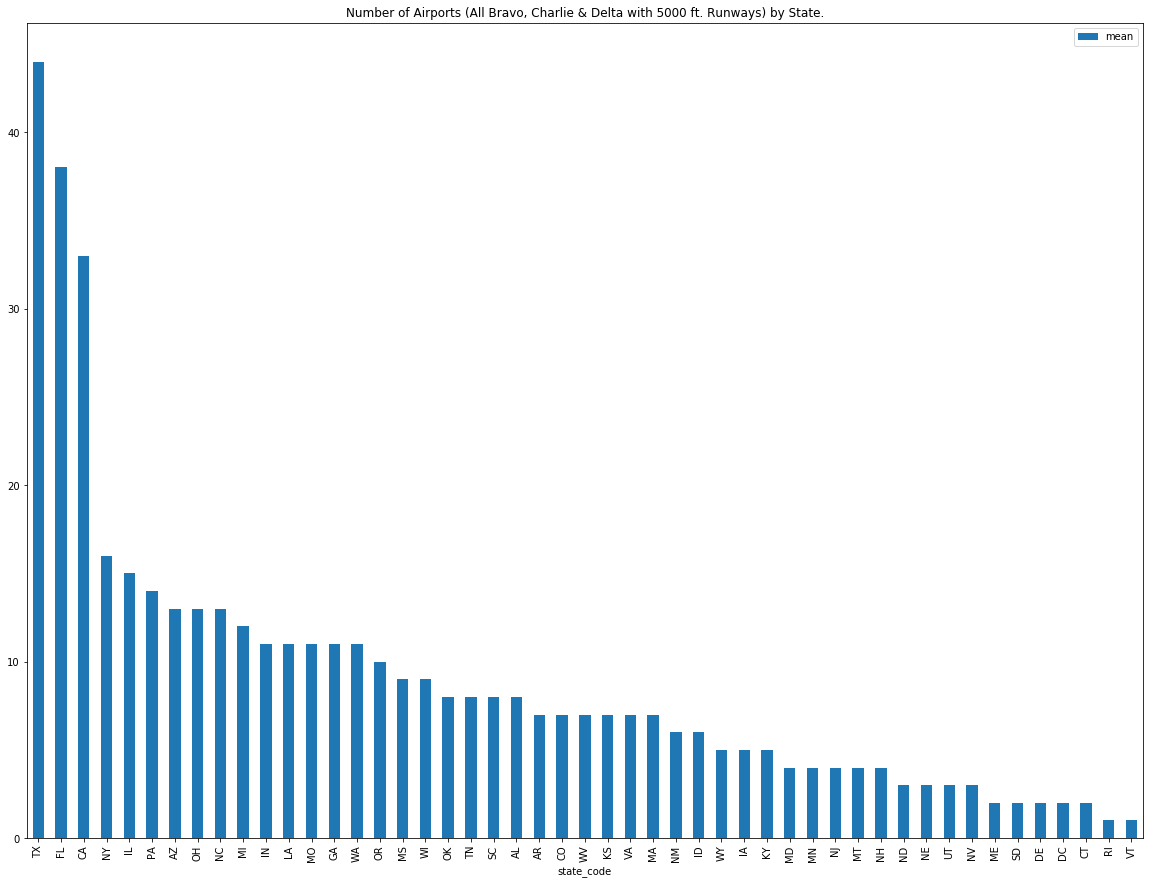

In [20]:
data_subset.groupby('state_code')[['mean']].count().reset_index().sort_values(by='mean', ascending=False).plot.bar(x='state_code', y='mean', figsize=(20,15), title="Number of Airports (All Bravo, Charlie & Delta with 5000 ft. Runways) by State.")

# Clustering The Airports

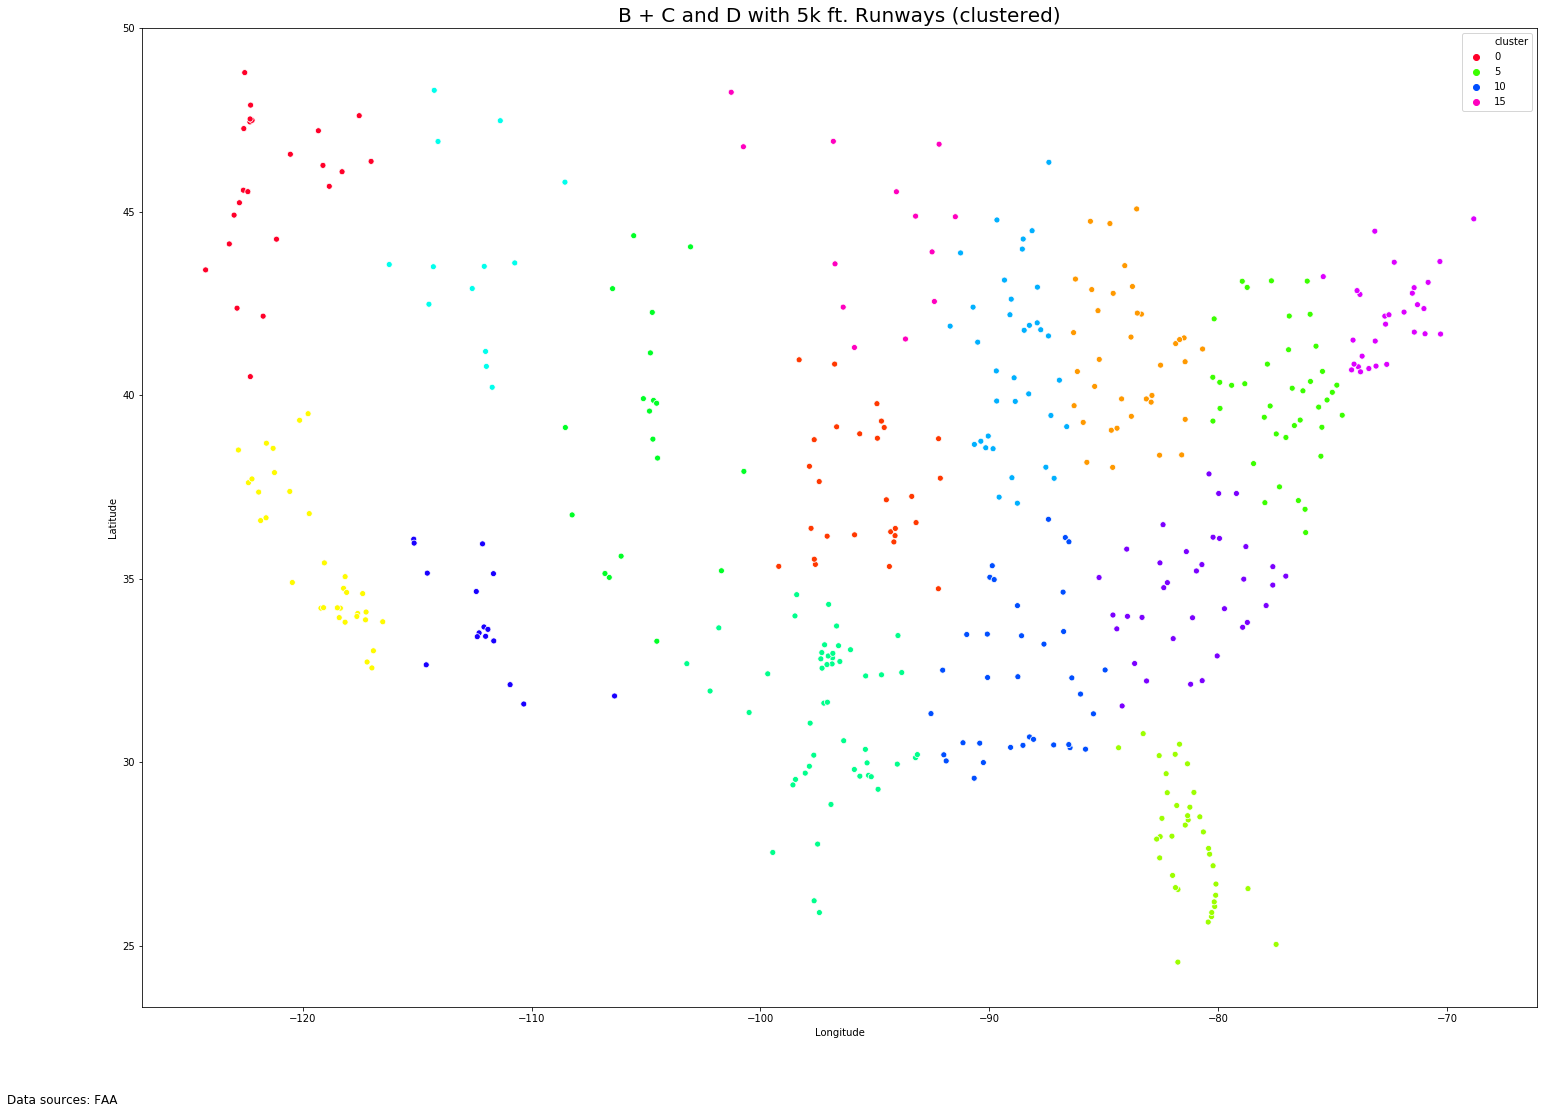

In [21]:
from sklearn.cluster import KMeans

#bravos = data_subset[data_subset['airspace'] == 'B']
#km = KMeans(n_clusters=len(bravos), init=bravos[['longitude', 'latitude']].values, n_init=1)
km = KMeans(n_clusters=15)

km.fit(data_subset[['longitude', 'latitude']].values)
data_subset['cluster'] = km.labels_
airport_map_plot(data_subset, title="B + C and D with 5k ft. Runways (clustered)", hue="cluster", palette='gist_rainbow');

# Build Airport Graph

In [22]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(data_subset['station_id'])

distances = {}

for x in data_subset['station_id']:
    for y in data_subset['station_id']:
        if (x,y) in distances:
            dist = distances[(x, y)]
        elif (y,x) in distances:
            dist = distances[(y, x)]
        else:
            a = data_subset.loc[x]
            b = data_subset.loc[y]
            dist = geo.haversine(a['longitude'], a['latitude'], b['longitude'], b['latitude'], miles=True)
            distances[(x,y)] = dist

        if (dist >= 20) and (dist <= 175):
            G.add_edge(x, y)

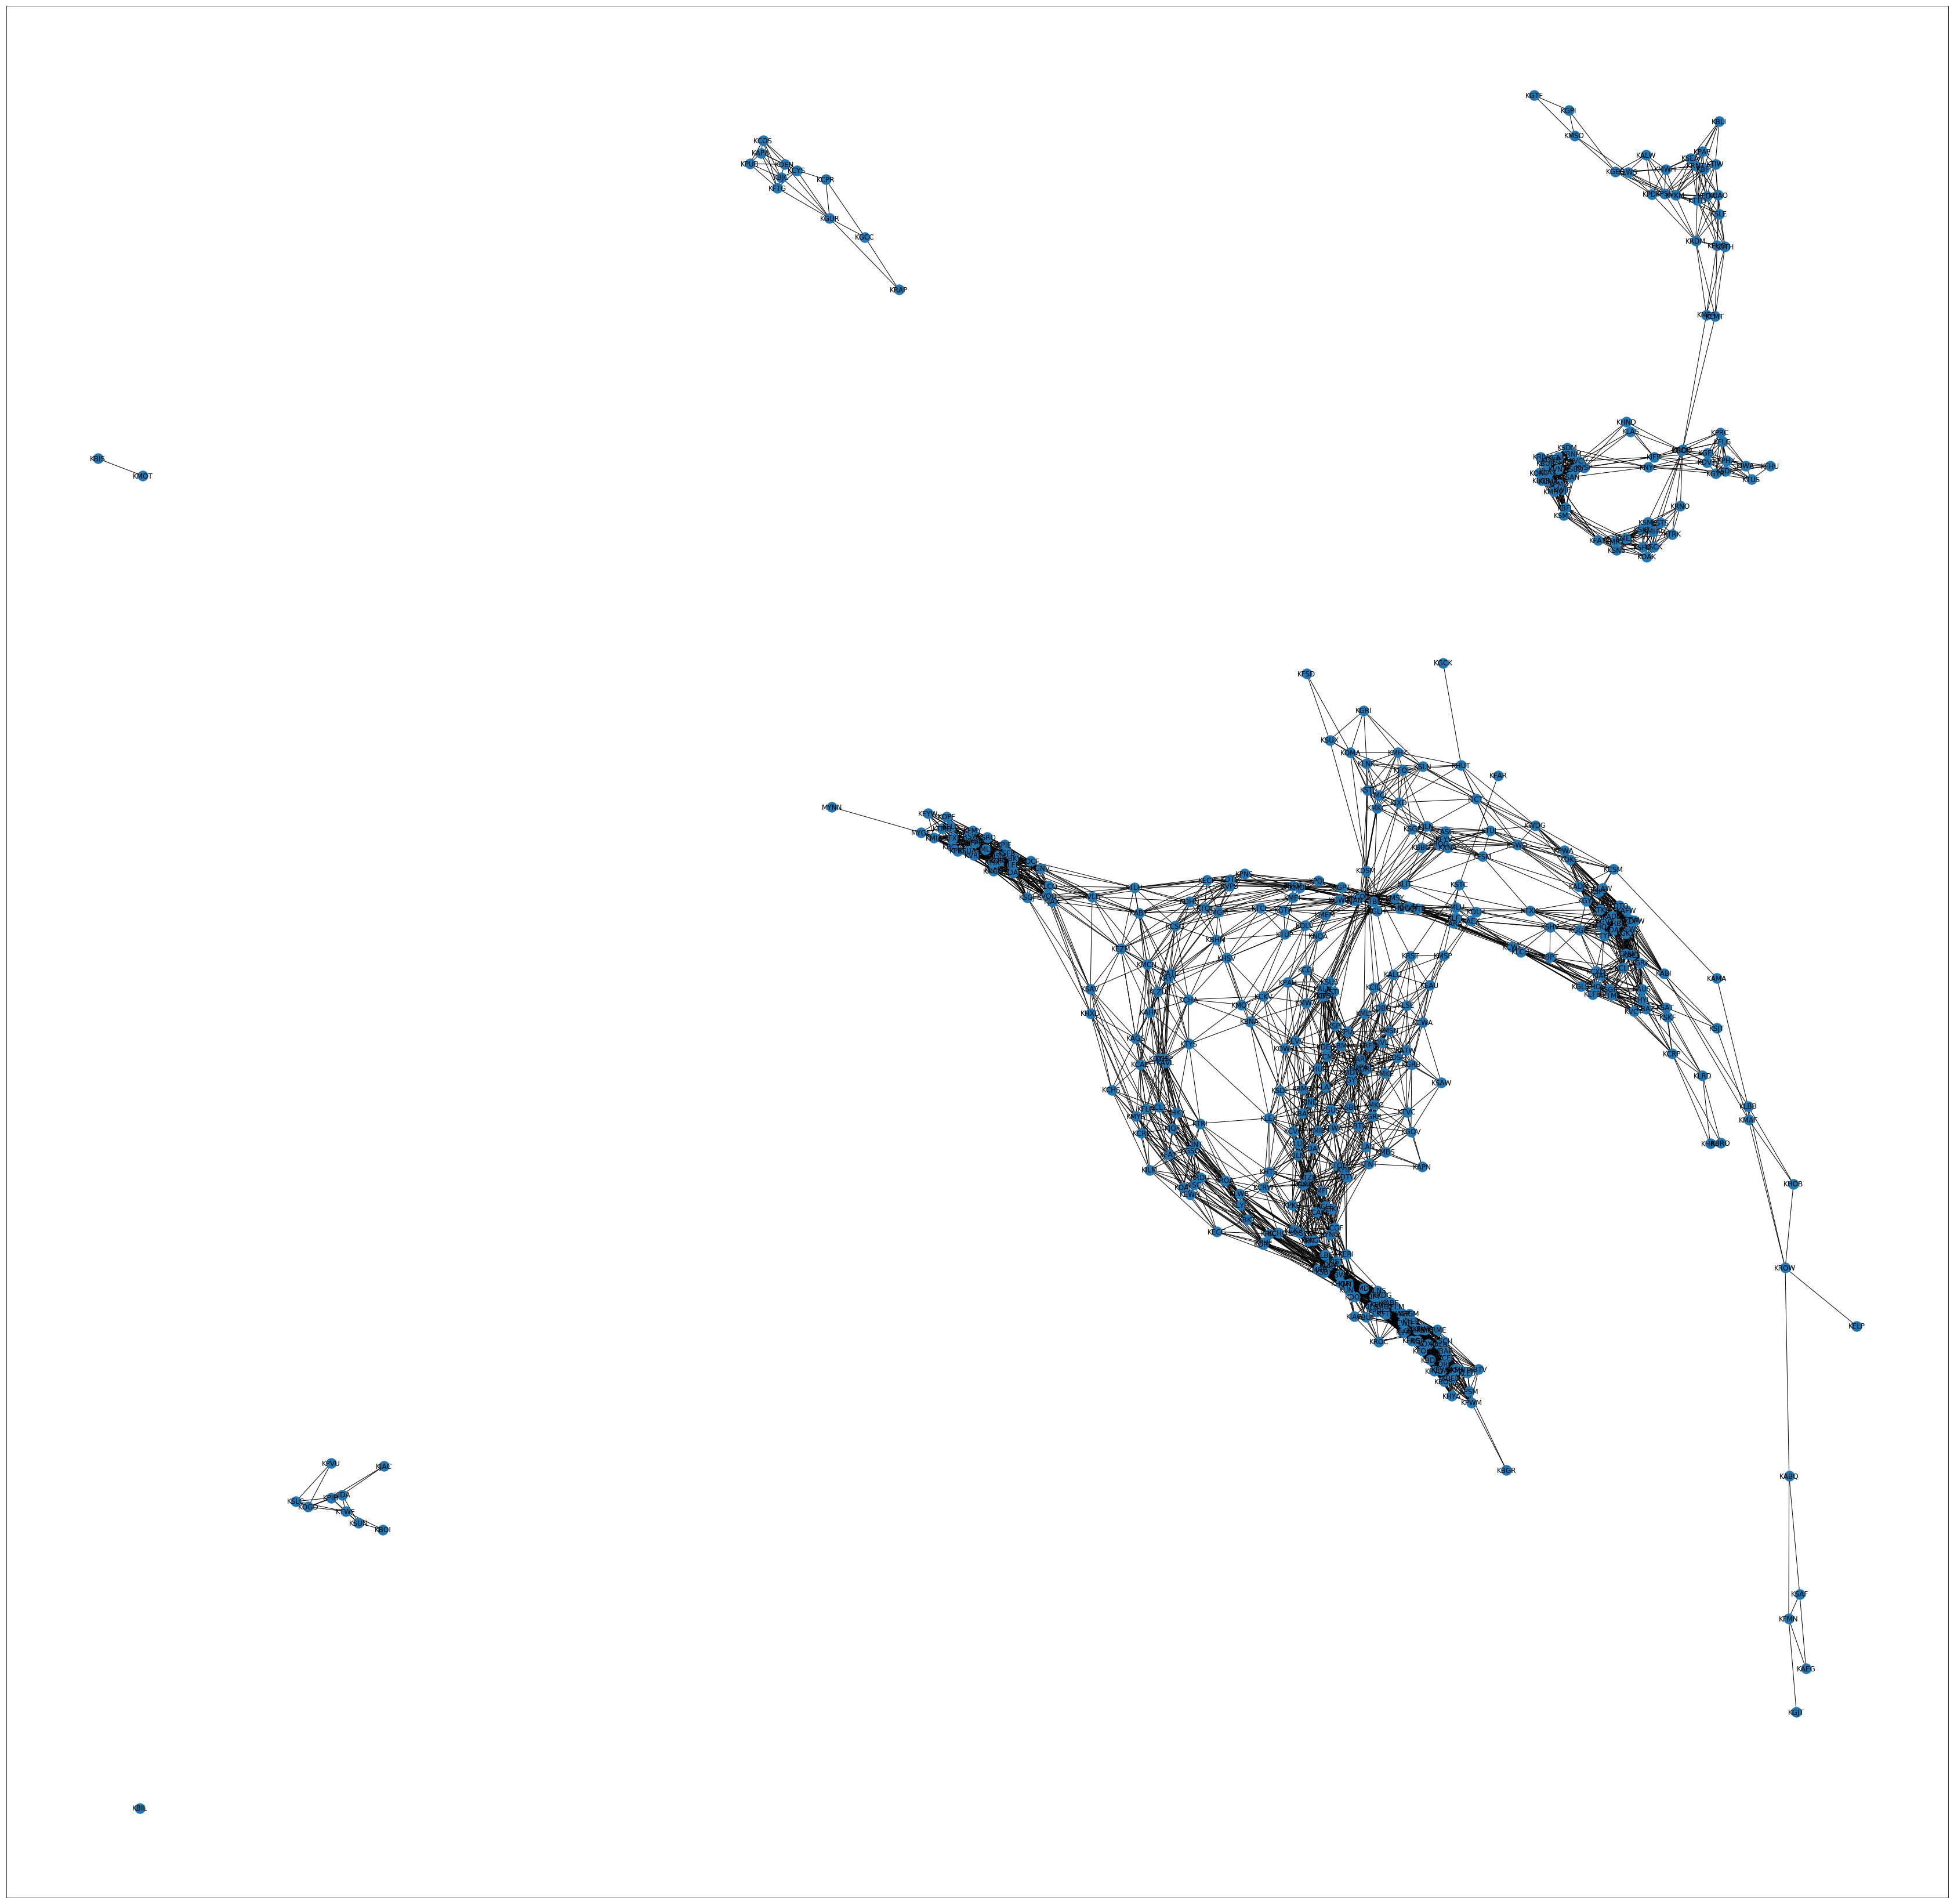

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(60, 60));
nx.draw_networkx(G, ax=ax)

In [24]:
data_subset['neighbors'] = data_subset['station_id'].apply(lambda x:len(list(G.neighbors(x))))

In [25]:
printout = data_subset.sort_values(by=['min_longitude', 'min_latitude', 'state_code', 'longitude','latitude'])[['faa_id','name', 'state_code', 'state_name', 'longitude_dms', 'latitude_dms', 'airspace','neighbors']]
printout.to_excel('data/printout.xls')

In [26]:
data.loc['KACT']

station_id                                                            KACT
faa_id                                                                 ACT
latitude_dms                                                31-36-43.9000N
longitude_dms                                              097-13-49.1000W
name                                                             WACO RGNL
city                                                                  WACO
state_code                                                              TX
state_name                                                           TEXAS
mean                                                                  6105
count                                                                    2
max                                                                   7107
min                                                                   5103
latitude                                                           31.6122
longitude                

In [27]:
def midpoint(x1, y1, x2, y2):
    import math
    #Input values as degrees

    #Convert to radians
    lat1 = math.radians(y1)
    lon1 = math.radians(x1)
    lat2 = math.radians(y2)
    lon2 = math.radians(x2)


    bx = math.cos(lat2) * math.cos(lon2 - lon1)
    by = math.cos(lat2) * math.sin(lon2 - lon1)
    lat3 = math.atan2(math.sin(lat1) + math.sin(lat2), \
           math.sqrt((math.cos(lat1) + bx) * (math.cos(lat1) \
           + bx) + by**2))
    lon3 = lon1 + math.atan2(by, math.cos(lat1) + bx)

    return [round(math.degrees(lon3), 2), round(math.degrees(lat3), 2)]


In [203]:
def distance(a, b):
    lona, lata = (data.loc[a]['longitude'], data.loc[a]['latitude'])
    lonb, latb = (data.loc[b]['longitude'], data.loc[b]['latitude'])
    distance = geo.haversine(lona, lata, lonb, latb, miles=True)
    return distance

In [177]:
def build_map(data):
    plt.figure(figsize=(30,20))
    #m = Basemap(width=5000000,height=4000000,
    #    projection='lcc', resolution='l',lat_1=45.,lat_2=55,lat_0=40,lon_0=-97.)
    m = Basemap(width=5000000,height=3500000,
        projection='lcc', resolution='l',lat_1=45.,lat_2=55,lat_0=40,lon_0=-97.)
    #m.shadedrelief()
    m.drawcoastlines()
    m.drawstates()
    m.drawcountries()

    x, y = m(
        list(data['longitude']),
        list(data['latitude']))
    
    airspace_colors = {'B':'blue', 'D':'red', 'C':'magenta', 'E':'green', 'G': 'black'}
    
    m.scatter(x,y, marker='o', c=data['airspace'].apply(lambda x:airspace_colors[x]), s=30)
    
    for i in range(len(data) - 1):
        point_a = data.iloc[i]
        point_b = data.iloc[i+1]
        nylon = point_a['longitude']
        nylat = point_a['latitude']
        lonlon = point_b['longitude']
        lonlat = point_b['latitude']
        
        distance = int(geo.haversine(nylon, nylat, lonlon, lonlat, miles=True))
        mid = midpoint(nylon, nylat, lonlon, lonlat)
        mid_x, mid_y = m(*mid)
        color = 'red' if distance >= 175 else 'black'
        m.drawgreatcircle(nylon,nylat,lonlon,lonlat,linewidth=1,color=color)
        plt.text(mid_x, mid_y, str(distance), fontsize=10, ha='left', va='bottom', color=color)
        
    
    for i in range(len(data)):
        place = data.iloc[i]
        lon = x[i]
        lat = y[i]
        ident = place['faa_id']
        plt.text(lon, lat, ident, fontsize=12,fontweight='bold',
                    ha='left',va='bottom',color='black')
    plt.show()

There are 172 airports on the map


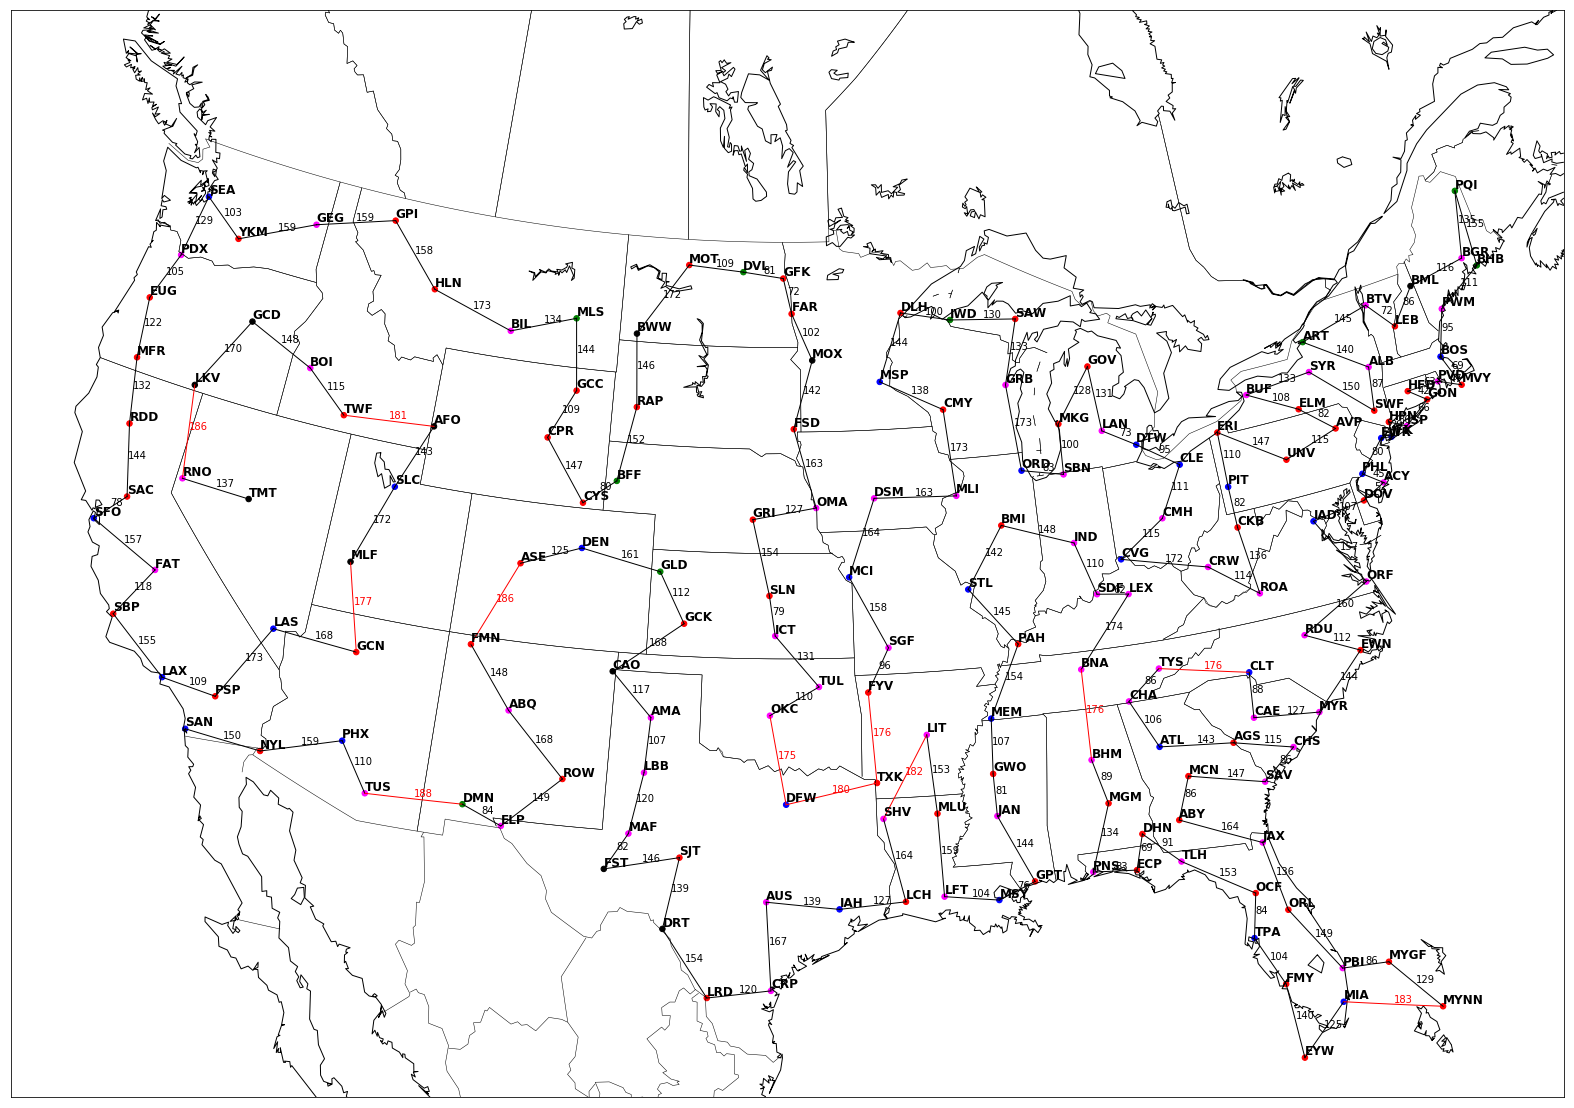

In [211]:
chosen_airports = [
    'SAN',
    'NYL',
    'PHX',
    'TUS',
#    'DUG', # Douglas/Bisbee, AZ
    'DMN', # Deming, NM
    'ELP',
    'ROW',
    'ABQ',
    'FMN',
    'ASE',
    'DEN',
    'GLD',
    'GCK',
    'CAO',
    'AMA',
    'LBB',
    'MAF',
    'FST',
    'SJT',
    'DRT',
#    'SAT',  # San Antonio, TX
    'LRD',
    'CRP',
    'AUS',
    'IAH',
    'LCH',
    'SHV',
    'LIT',
    'MLU',
    'LFT',
    'MSY',
    'GPT',
    'JAN',
    'GWO',
#    'GTR',
#    'GLH',
    'MEM',
    'PAH',
    'STL',
    'BMI',
    'IND',
#    'EVV', # Evansville Regional Airport, ID
    'SDF',
    'LEX',
#    'EKX', Elizabethtown, KY
    'BNA',
    'BHM',
    'MGM',
#    'MOB', # Mobile, AL
    'PNS',
    'ECP',
    'DHN',
    'TLH',
    'OCF',
    'TPA',
    'FMY',
    'EYW',
    'MIA',
    'MYNN',
    'MYGF',
    'PBI',
#    'VRB', # Vero Beach, FL
    'ORL',
#    'DAB', # Daytona Beach, FL
    'JAX',
#    'VLD', # Valdosta, GA
    'ABY',
    'MCN',
    'SAV',
    'CHS',
    'AGS',
    'ATL',
#    'CTJ', Carrollton, GA
    'CHA',
    'TYS',
#    'AVL', # Ashville, NC
    'CLT',
    'CAE',
    'MYR',
    'EWN',
    'RDU',
#    'RIC',
    'ORF',
    'IAD',
    'DOV',
    'ACY',
    'PHL',
#    'ABE', # Allentown
    'EWR',
    'JFK',
    'HPN',
    'ISP',
#    'DXR', # Danbury
#    'HTO', # Easthampton, NY
    'GON',
    'HFD',
#    'CEF',
    'PVD',
    'MVY',
#    'ACK',  # Nantucket
    'BOS',
#    'MHT',
    'PWM',
    'BHB',
    'PQI',
    'BGR',
    'BML',
    'LEB',
    'BTV',
    'ART',
    'ALB',
    'SWF',
    'SYR',
#    'ROC',
    'BUF',
    'ELM',
    'AVP',
    'UNV',
    'ERI',
    'PIT',
#    'MRB',  # Eastern W. Va Regional
    'CKB',
    'ROA',
    'CRW',
#    'HTS', # Tri-State Huntington W. Va
    'CVG',
    'CMH',
    'CLE',
    'DTW',
    'LAN',
    'GOV',
    'MKG',
    'SBN',
    'ORD',
    'GRB',
    'SAW',
    'IWD',
    'DLH',
    'MSP',
    'CMY',
    'MLI',
    'DSM',
    'MCI',
    'SGF',
    'FYV',
    #FYV -> TXK -> DFW -> OKC -> TUL -> ICT
    'TXK',
    'DFW',
    'OKC',
    'TUL',
    'ICT',
#    'SPS', # Wichita Falls, TX
#    'WDG', # Enid, OK
    'SLN',
    'GRI',
    'OMA',
    'FSD',
    'MOX',
    'FAR',
    'GFK',
    'DVL',
    'MOT',
    'BWW',
    'RAP',
    'BFF',
    'CYS',
    'CPR',
    'GCC',
    'MLS',
    'BIL',
    'HLN',
    'GPI',
    'GEG',
    'YKM',
    'SEA',
    'PDX',
    'EUG',
    'MFR',
    'RDD',
    'SAC',
    'SFO',
#    'MRY',  # Monterey, CA
    'FAT',
    'SBP',
    'LAX',
    'PSP',
#    'IFP', # Bullhead City, AZ
    'LAS',
    'GCN',
    'MLF',
    'SLC',
    'AFO', 
    'TWF',
    'BOI',
    'GCD',
    'LKV',
#    'WMC',
    'RNO',
    'TMT'
    ]


missing_airports = [x for x in chosen_airports if x not in list(data['faa_id'])]

if len(missing_airports) > 0:
    print("ERROR: Missing data for: {}".format(missing_airports))
else:
    chosen_airports_df = data[data['faa_id'].isin(chosen_airports)]
    chosen_airports_df.index=chosen_airports_df['faa_id']
    chosen_airports_df = chosen_airports_df.loc[chosen_airports]
    print("There are {} airports on the map".format(len(chosen_airports_df)))
    build_map(chosen_airports_df);

In [210]:
distance('KSHV', 'KLIT')

182.6615098515463

AUS -> IAH
SHV -> LIT
FYV -> TXK -> DFW -> OKC -> TUL -> ICT